In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
from torchvision import transforms as T
import torch.nn as nn
import torch.nn.functional as nnF
import data_loader
from PIL import Image

In [32]:
#Import and initialize dataloaders
train_loader, val_loader, test_loader = data_loader.get_dataloader(path="~/Projects/COVID19-Transfer-Learning/COVID19-Transfer-Learning/Data/")

In [35]:
#Create model
class FeatureExtractorNetwork(nn.Module):
    def __init__(self, model):
        super(FeatureExtractorNetwork, self).__init__()
        
        #Feature extractor
        self.features = nn.Sequential(*list(model.children())[:-1])
        self.features.trainable = False
        layers = list(model.children())
        features = layers[-1].in_features
        self.flatten = nn.Flatten()
        
        #Fully connected layers
        self.fc1 = nn.Linear(features, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1)
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = nnF.relu(self.fc1(x))
        x = nnF.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [36]:
#Check that model runs on a random tensor
test_model = FeatureExtractorNetwork(torchvision.models.resnet18())
x=torch.randn(1,3,224,224)
output = test_model(x)
print(output)

tensor([[0.4565]], grad_fn=<SigmoidBackward0>)


In [37]:
#Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
#Define training function
def train(model,optimizer,train_dataloader,val_dataloader,criterion):
    #Set model to training mode
    model.train()
    
    #Initialize loss and accuracy
    train_loss = 0
    train_accuracy = 0
    
    for data in train_dataloader:
        #Get data and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Zero the gradients
        optimizer.zero_grad()
        
        #Forward pass
        outputs = model(inputs).flatten()
        loss = criterion(outputs, labels.float())
        
        #Backward pass
        loss.backward()
        optimizer.step()
        
        #Calculate loss and accuracy
        train_loss += loss.item()
        train_accuracy += (outputs.round() == labels).sum().item()
    
    #Calculate average loss and accuracy
    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataloader.dataset)
    
    #Initialize loss and accuracy
    val_loss = 0
    val_accuracy = 0
    
    for data in val_dataloader:
        #Get data and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Forward pass
        outputs = model(inputs).flatten()
        loss = nnF.binary_cross_entropy(outputs, labels.float())
        
        #Calculate loss and accuracy
        val_loss += loss.item()
        val_accuracy += (outputs.round() == labels).sum().item()
    
    #Calculate average loss and accuracy
    val_loss /= len(val_dataloader)
    val_accuracy /= len(val_dataloader.dataset)
    
    return train_loss, train_accuracy, val_loss, val_accuracy

#### From Scratch

In [41]:
resnet50 = torchvision.models.resnet50()
model = FeatureExtractorNetwork(resnet50).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.BCELoss()

loss_train_list=[]
acc_train_list=[]
loss_val_list = []
acc_val_list = []

best_val = 0
best_model = None

for epoch in range(0, 100):
    #-------- perform training --------------------------------
    loss_train, acc_train, loss_val, acc_val = train(model,optimizer,train_loader,val_loader,criterion)
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    
    if acc_val > best_val:
        best_val = acc_val
        best_model = model.state_dict()
        

    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train, 'val acc:', acc_val)

epoch 0 training loss: 0.6980582531541586 acc: 0.6152324431256182 val acc: 0.7833333333333333
epoch 1 training loss: 0.4252713546156883 acc: 0.8175074183976261 val acc: 0.85
epoch 2 training loss: 0.3862704182974994 acc: 0.8367952522255193 val acc: 0.85
epoch 3 training loss: 0.365499003441073 acc: 0.8437190900098912 val acc: 0.75
epoch 4 training loss: 0.3165032451506704 acc: 0.8714144411473789 val acc: 0.85
epoch 5 training loss: 0.2923225442355033 acc: 0.8778437190900099 val acc: 0.8666666666666667
epoch 6 training loss: 0.2705284378025681 acc: 0.8911968348170128 val acc: 0.8
epoch 7 training loss: 0.32547595957294106 acc: 0.8728981206726014 val acc: 0.9
epoch 8 training loss: 0.2894209863152355 acc: 0.8788328387734916 val acc: 0.8833333333333333
epoch 9 training loss: 0.25920520443469286 acc: 0.8946587537091988 val acc: 0.8833333333333333
epoch 10 training loss: 0.25692870910279453 acc: 0.8991097922848664 val acc: 0.8333333333333334
epoch 11 training loss: 0.23278681479860097 acc: 

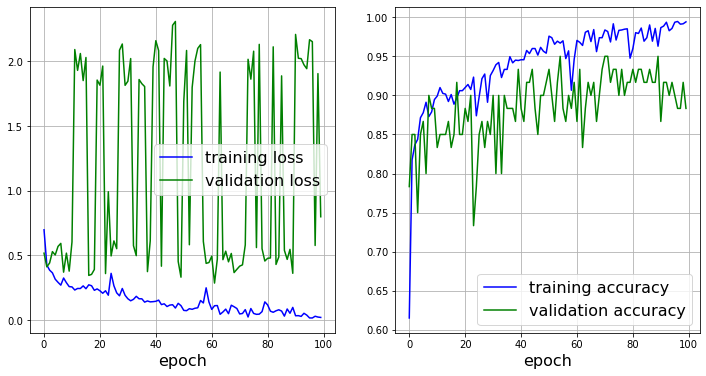

In [42]:
#Plot the loss and accuracy results
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-g', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

In [44]:
model.load_state_dict(best_model)
test_accuracy = 0

for data in test_loader:
    #Get data and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    
    #Forward pass
    outputs = model(inputs).flatten()
    loss = nnF.binary_cross_entropy(outputs, labels.float())
    
    #Calculate accuracy
    test_accuracy += (outputs.round() == labels).sum().item()
    
#Calculate average loss and accuracy
test_accuracy /= len(test_loader.dataset)
print(test_accuracy)

0.9175


In [45]:
#Save best model for future use
torch.save({'model_state_dict': best_model},'model.pt')

In [4]:
#Load best model if needed
checkpoint=torch.load('model.pt')
model = FeatureExtractorNetwork(torchvision.models.resnet50())
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Pretrained Model

In [46]:
pre_trained_resnet50 = torchvision.models.resnet50(weights='IMAGENET1K_V2')
for param in pre_trained_resnet50.parameters():
    param.requires_grad = False
pre_trained_model = FeatureExtractorNetwork(pre_trained_resnet50).to(device)

optimizer = torch.optim.Adam(pre_trained_model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.BCELoss()

loss_train_list=[]
acc_train_list=[]
loss_val_list = []
acc_val_list = []

best_val = 0
best_model = None

for epoch in range(0, 100):
    #-------- perform training --------------------------------
    loss_train, acc_train, loss_val, acc_val = train(pre_trained_model,optimizer,train_loader,val_loader,criterion)
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    
    if acc_val > best_val:
        best_val = acc_val
        best_model = pre_trained_model.state_dict()
        

    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train, 'val acc:', acc_val)

epoch 0 training loss: 0.38042236771434546 acc: 0.837784371909001 val acc: 0.85
epoch 1 training loss: 0.1926431845058687 acc: 0.9233432245301681 val acc: 0.85
epoch 2 training loss: 0.1611247175023891 acc: 0.9307616221562809 val acc: 0.8666666666666667
epoch 3 training loss: 0.1043725397757953 acc: 0.9549950544015826 val acc: 0.8333333333333334
epoch 4 training loss: 0.188852539184154 acc: 0.93026706231454 val acc: 0.8833333333333333
epoch 5 training loss: 0.0691888499786728 acc: 0.9727992087042532 val acc: 0.9
epoch 6 training loss: 0.07299240001884755 acc: 0.9762611275964391 val acc: 0.8666666666666667
epoch 7 training loss: 0.03479871828130854 acc: 0.9876360039564788 val acc: 0.8833333333333333
epoch 8 training loss: 0.03756781818219679 acc: 0.9841740850642928 val acc: 0.9166666666666666
epoch 9 training loss: 0.059777376478450606 acc: 0.9777448071216617 val acc: 0.9
epoch 10 training loss: 0.0509805382534978 acc: 0.9841740850642928 val acc: 0.85
epoch 11 training loss: 0.020230928

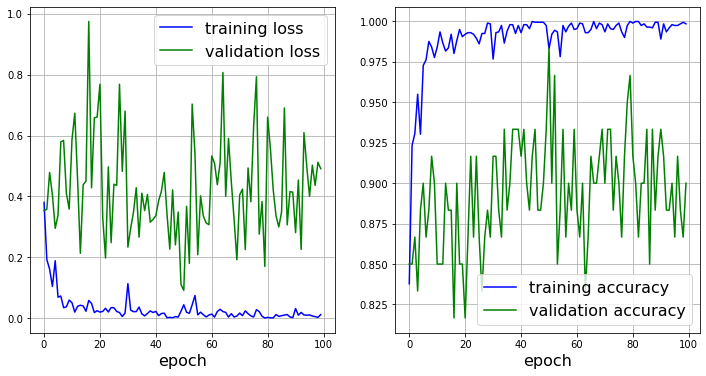

In [47]:
#Plot the loss and accuracy results
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-g', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

In [51]:
pre_trained_model.load_state_dict(best_model)
test_accuracy = 0

for data in test_loader:
    #Get data and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    #Forward pass
    outputs = pre_trained_model(inputs).flatten()
    loss = nnF.binary_cross_entropy(outputs, labels.float())
    
    #Calculate accuracy
    test_accuracy += (outputs.round() == labels).sum().item()
    
#Calculate average loss and accuracy
test_accuracy /= len(test_loader.dataset)
print(test_accuracy)

0.94


In [49]:
#Save best model for future use
torch.save({'model_state_dict': best_model},'pre_trained_model.pt')

In [10]:
#Load best model if needed
checkpoint=torch.load('pretrained_model.pt')
pre_trained_model = FeatureExtractorNetwork(torchvision.models.resnet50())
pre_trained_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### CAM Analysis

In [ ]:
import IPython.display as display
import skimage.io as io
import skimage
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

#Get test data
test_images = ['NORMAL/Non-Covid (1207).png','NORMAL/Non-Covid (472).png','NORMAL/Non-Covid (1028).png',
               'NORMAL/Non-Covid (959).png','NORMAL/Non-Covid (670).png','COVID/Covid (962).png',
               'COVID/Covid (1243).png','COVID/Covid (1078).png','COVID/Covid (92).png','COVID/Covid (603).png']

scratch_cam = GradCAM(model=model, target_layers=model.features)
images = torch.zeros(10,224,224)
inputs = torch.zeros(10,3,224,224)
labels = torch.zeros(10, dtype=torch.int64)

for i,path in enumerate(test_images):
    path = '/fs/johnston/home/cole/Projects/COVID19-Transfer-Learning/COVID19-Transfer-Learning/Data/'+path
    image = Image.open(path)
    I=io.imread(path)
    I2=skimage.util.img_as_float32(I)
    I2 = I2.reshape(1,I2.shape[0],I2.shape[1])
    I2 = torch.tensor(I2, dtype=torch.float32)
    I2 = I2.expand(3, I2.shape[1],I2.shape[2])
    if i < 6:
        label = 0
    else:
        label = 1
    print(image.size)
    images[i] = image
    inputs[i] = I2
    labels[i] = label

print(type(labels))
grayscale_cam = scratch_cam(input_tensor=inputs, targets=None)
    
visualization = show_cam_on_image(images, grayscale_cam, use_rgb=True)
#display.display(image) 

In [89]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2

scratch_cam = GradCAM(model=model, target_layers=model.features)

path = '/fs/johnston/home/cole/Projects/COVID19-Transfer-Learning/COVID19-Transfer-Learning/Data/NORMAL/Non-Covid (1207).png'
rgb_img = cv2.imread(path, 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])

grayscale_cam = scratch_cam(input_tensor=input_tensor, targets=None)
grayscale_cam = grayscale_cam[0, :]
    
visualization = show_cam_on_image(rgb_img, grayscale_cam)
#display.display(image) 

#### GradCAM

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

scratch_cam = GradCAM(model=model, target_layers=model.features)

for x,y in test_loader:
    grayscale_cam = scratch_cam(input_tensor=x, targets=y)
    
    visualization = show_cam_on_image(, grayscale_cam, use_rgb=True)

# In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)